## Mixed layer tracer structure

In this notebook we explore the structure of the mixed layer. The properties we look at are: 
- Homogeneity of the mixed layer as a function of time/space. 
- Are density gradients in the ML constructed by T or S, or both? 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
import hvplot.xarray
import panel as pn
pn.extension()

In [4]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_binned_29_june_2021.nc')

In [35]:
# drop profiles where we don't have data near the surface.
ds_660_grid = ds_660_grid.where(~np.isnan(ds_660_grid.sigma0.sel(ctd_pressure=15, method='nearest')), drop=True)

In [36]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1003)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 27.03 27.02 27.02 ... nan nan
    SA            (ctd_pressure, dives) float64 34.15 34.15 34.15 ... nan nan
    CT            (ctd_pressure, dives) float64 3.59 3.618 3.617 ... nan nan nan
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 -51.5 -51.49 -51.48 ... nan nan
    longitude     (ctd_pressure, dives) float64 30.03 30.03 30.05 ... nan nan
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

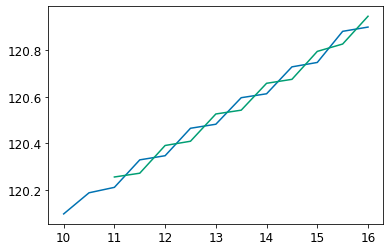

In [17]:
days = ds_660_grid.time - np.datetime64('2019-01-01')
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

temp_var = ds_660_grid['days'].sel(dives=slice(10,16))
plt.plot(temp_var.dives, temp_var.sel(ctd_pressure=30, method='nearest'))
plt.plot(temp_var.dives, temp_var.sel(ctd_pressure=800, method='nearest'))

In [61]:
ds_660_grid.load()

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] ...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-28 15:33:51] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

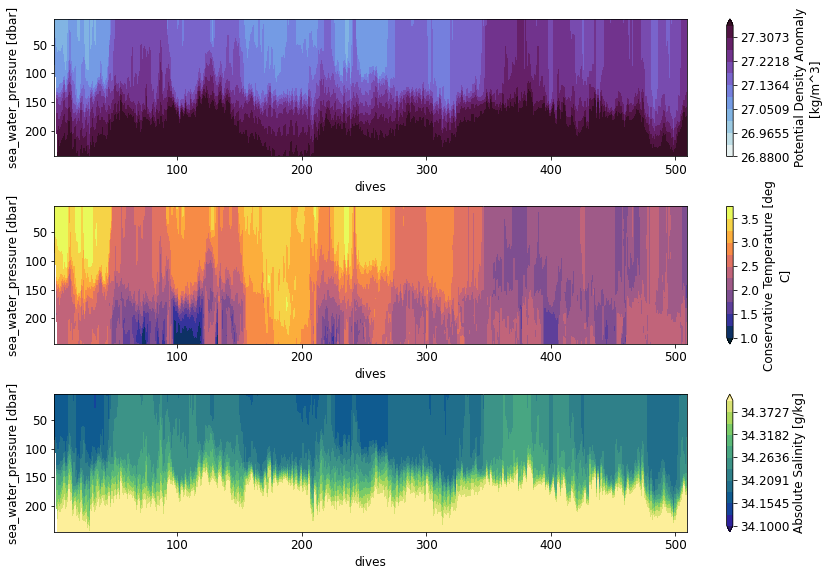

In [18]:
plt.figure(figsize=(12,8))

plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(26.88, 27.35,12), 
                                                                                   cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.subplot(312)
ds_660_grid.CT.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(1, 3.75,12),
                                                                     cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.subplot(313)
ds_660_grid.SA.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(34.1, 34.4,12),
                                                                  cmap=cmo.haline)
plt.gca().invert_yaxis()

plt.tight_layout()

### Near surface layer properties

In [46]:
SA_lin = np.linspace(34.0, 34.3, 51)
CT_lin = np.linspace(1.5, 4, 51)

[SA_grid, CT_grid] = np.meshgrid(SA_lin, CT_lin)

rho_grid = gsw.sigma0(SA_grid, CT_grid)

Text(0, 0.5, 'CT')

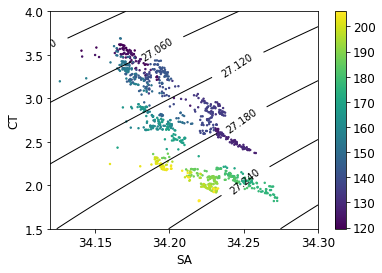

In [47]:

CS = plt.contour(SA_lin, CT_lin, rho_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            s=2.,
            c=ds_660_grid.days.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'))
plt.colorbar()

plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

Text(0, 0.5, 'CT')

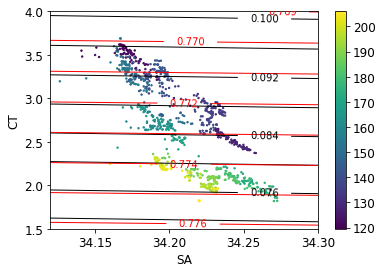

In [97]:
rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*rho0
beta_grid = gsw.beta(SA_grid, CT_grid,50)*rho0

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'), 
            s=2.,
            c=ds_660_grid.days.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure'))
plt.colorbar()


plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

In [88]:
# Estimate the alpha and beta 

alpha = (gsw.alpha(34.20, 2.75, 0))
beta = (gsw.beta(34.20, 2.75, 0))

drho = .3
dt = drho/alpha/1000
ds = drho/beta/1000

display(alpha)
display(beta)

8.468229088219696e-05

0.0007731467820367002

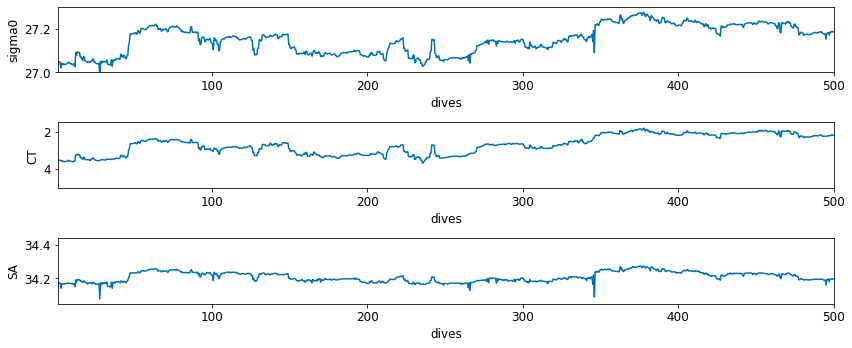

In [49]:
plt.figure(figsize=(12,5))
plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,500])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,500])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,500])

plt.tight_layout()


### Mixed layer 

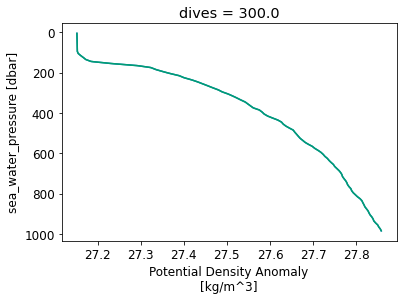

In [24]:
ds_660_grid.sigma0.sel(dives=300).plot(y='ctd_pressure')
ds_660_grid.sigma0.sel(dives=300).interp(ctd_pressure=np.linspace(0,1000,501)).plot(y='ctd_pressure')
plt.gca().invert_yaxis()

In [50]:
def find_mld(ds, thresh=0.03):
    
    dens= ds.sigma0.interp(ctd_pressure=np.linspace(0,1000,501))
    temp = ds.CT.interp(ctd_pressure=np.linspace(0,1000,501))
    salt = ds.SA.interp(ctd_pressure=np.linspace(0,1000,501))
    
    time = ds.days.interp(ctd_pressure=np.linspace(0,1000,501))    
    lat = ds.latitude.interp(ctd_pressure=np.linspace(0,1000,501))    
    lon = ds.longitude.interp(ctd_pressure=np.linspace(0,1000,501))    
    
    
    #dens = dens.interp(ctd_pressure=np.linspace(0,1000,501))
    
    dens15 = dens.sel(ctd_pressure = 15., method='nearest')
    
    delta_dens = dens - dens15
    delta_dens_crit = delta_dens.where(delta_dens>=thresh)
    
    MLD = delta_dens.ctd_pressure.where(delta_dens==
                                    delta_dens_crit.min(['ctd_pressure'])
                                       ).max(['ctd_pressure']).rename('mld')
    
    MLD_temp = temp.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_salt = salt.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_dens = dens.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    
    MLD_time = time.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_lat = lat.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    MLD_lon = lon.where(delta_dens<=thresh).mean('ctd_pressure',skipna=True)
    
    
    mld_properties = xr.merge([MLD,
                               MLD_temp, MLD_salt, MLD_dens, 
                               MLD_time, MLD_lat, MLD_lon])
    
    return mld_properties

In [51]:
MLD = find_mld(ds_660_grid, thresh=0.03)


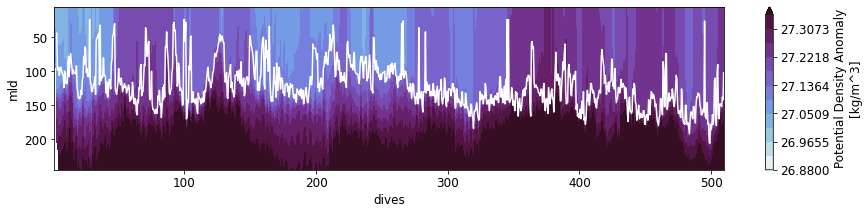

In [52]:
plt.figure(figsize=(15,3))
ds_660_grid.sigma0.sel(ctd_pressure=slice(0,250)).plot.contourf(levels=np.linspace(26.88, 27.35,12), 
                                                                                   cmap=cmo.dense)
MLD.mld.plot(color='w')
plt.gca().invert_yaxis()

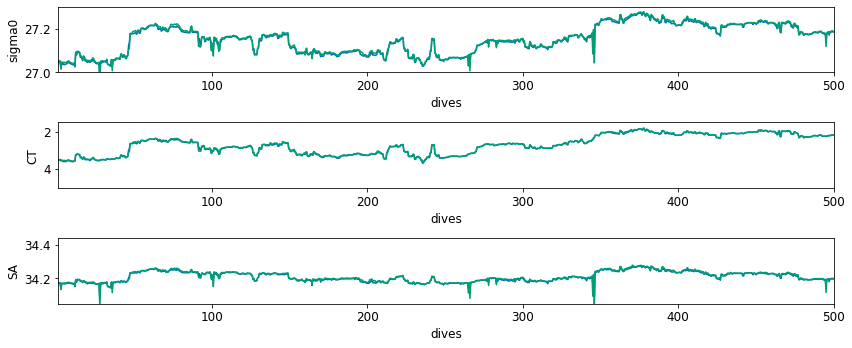

In [53]:
plt.figure(figsize=(12,5))
plt.subplot(311)
ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.sigma0.plot()
plt.ylim([27. , 27+drho])
plt.xlim([1,500])

plt.subplot(312)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.CT.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.CT.plot()
plt.ylim([1.5 , 1.5+dt])
plt.gca().invert_yaxis()
plt.xlim([1,500])


plt.subplot(313)
#ds_660_grid.sigma0.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
ds_660_grid.SA.sel(ctd_pressure=slice(10,50)).mean('ctd_pressure').plot()
MLD.SA.plot()
plt.ylim([34.05 , 34.05+ds])
plt.xlim([1,500])

plt.tight_layout()
# looks the same whether using 10-50m or full ML 

In [73]:
MLD.mld.hvplot(flip_yaxis=True)

:Curve   [dives]   (mld)

#### Check out what is going on with really shallow MLDs

This set looks like it is from the south, as indicated by deep cold anomaly. 

In [70]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.sigma0.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.sigma0.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (sigma0)
   .Curve.II  :Curve   [ctd_pressure]   (sigma0)
   .Curve.III :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV  :Curve   [ctd_pressure]   (sigma0)
   .Curve.V   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI  :Curve   [ctd_pressure]   (sigma0)

In [71]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.CT.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.CT.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (CT)
   .Curve.II  :Curve   [ctd_pressure]   (CT)
   .Curve.III :Curve   [ctd_pressure]   (CT)
   .Curve.IV  :Curve   [ctd_pressure]   (CT)
   .Curve.V   :Curve   [ctd_pressure]   (CT)
   .Curve.VI  :Curve   [ctd_pressure]   (CT)

In [72]:
n=0
for i in [125, 126, 127,128, 129, 130]:
    if n==0:
        plot = ds_660_grid.SA.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.SA.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I   :Curve   [ctd_pressure]   (SA)
   .Curve.II  :Curve   [ctd_pressure]   (SA)
   .Curve.III :Curve   [ctd_pressure]   (SA)
   .Curve.IV  :Curve   [ctd_pressure]   (SA)
   .Curve.V   :Curve   [ctd_pressure]   (SA)
   .Curve.VI  :Curve   [ctd_pressure]   (SA)

There are also some really fresh lenses sitting at the surface. 

In [62]:
shallow_mlds = MLD.mld.where(MLD.mld<40, drop=True)
shallow_mlds

<xarray.DataArray 'mld' (dives: 18)>
array([24., 32., 36., 30., 36., 32., 28., 24., 24., 28., 34., 32., 30.,
       26., 36., 24., 24., 26.])
Coordinates:
  * dives    (dives) float64 28.0 36.0 46.5 47.0 ... 278.0 345.0 346.0 495.0

In [74]:
n=0
for i in shallow_mlds.dives:
    if n==0:
        plot = ds_660_grid.sigma0.sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*ds_660_grid.sigma0.sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I     :Curve   [ctd_pressure]   (sigma0)
   .Curve.II    :Curve   [ctd_pressure]   (sigma0)
   .Curve.III   :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.V     :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.VII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.IX    :Curve   [ctd_pressure]   (sigma0)
   .Curve.X     :Curve   [ctd_pressure]   (sigma0)
   .Curve.XI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIV   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVI   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVIII :Curve   [ctd_pressure]   (sigma0)

In [75]:
n=0
for i in shallow_mlds.dives:
    if n==0:
        plot = (ds_660_grid.sigma0 - ds_660_grid.sigma0.sel(ctd_pressure=0, method='nearest')).sel(dives=i).hvplot()
        n=n+1
    else:
        plot = plot*(ds_660_grid.sigma0 - ds_660_grid.sigma0.sel(ctd_pressure=0, method='nearest')).sel(dives=i).hvplot()
plot        

:Overlay
   .Curve.I     :Curve   [ctd_pressure]   (sigma0)
   .Curve.II    :Curve   [ctd_pressure]   (sigma0)
   .Curve.III   :Curve   [ctd_pressure]   (sigma0)
   .Curve.IV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.V     :Curve   [ctd_pressure]   (sigma0)
   .Curve.VI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.VII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.VIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.IX    :Curve   [ctd_pressure]   (sigma0)
   .Curve.X     :Curve   [ctd_pressure]   (sigma0)
   .Curve.XI    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XII   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XIV   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XV    :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVI   :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVII  :Curve   [ctd_pressure]   (sigma0)
   .Curve.XVIII :Curve   [ctd_pressure]   (sigma0)

### Start considering distances. 

First consider a couple of options for distances. 

In [84]:
MLD

<xarray.Dataset>
Dimensions:    (dives: 1003)
Coordinates:
  * dives      (dives) float64 1.0 1.5 2.0 2.5 3.0 ... 508.0 508.5 509.0 509.5
Data variables:
    mld        (dives) float64 nan nan nan nan 44.0 ... 152.0 138.0 142.0 102.0
    CT         (dives) float64 3.543 3.535 3.501 3.493 ... 1.812 1.818 1.793
    SA         (dives) float64 34.18 34.17 34.17 34.17 ... 34.22 34.22 34.23
    sigma0     (dives) float64 27.05 27.05 27.05 27.05 ... 27.24 27.24 27.24
    days       (dives) float64 119.5 119.5 119.5 119.6 ... 205.8 205.8 206.0
    latitude   (dives) float64 -51.49 -51.49 -51.48 ... -51.54 -51.53 -51.52
    longitude  (dives) float64 30.03 30.03 30.05 30.05 ... 38.98 38.99 39.03
    X          (dives) float64 8.717e+03 8.996e+03 ... 6.279e+05 6.31e+05
    Y          (dives) float64 2.784e+05 2.788e+05 ... 2.741e+05 2.757e+05
    distance   (dives) float64 0.0 422.5 1.962e+03 ... 1.778e+06 1.781e+06

In [77]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [78]:
# convert to distance coordinate

# set coordinates at 30E lon and -54S
ref_x = 29.9,
ref_y = -54
deg2m = 111139.

def lonlat2xy(ds, ref_x, reg_y):
    deg2m = 111139.
    
    X = great_circle_distance(ds.longitude, ds.latitude, 
                              ref_x, ds.latitude)*deg2m
    Y = great_circle_distance(ds.longitude, ds.latitude, 
                              ds.longitude, ref_y)*deg2m

    return X.rename('X'), Y.rename('Y')


In [79]:
MLD['X'], MLD['Y'] = lonlat2xy(xr.merge([MLD.longitude, MLD.latitude]), ref_x, ref_y)

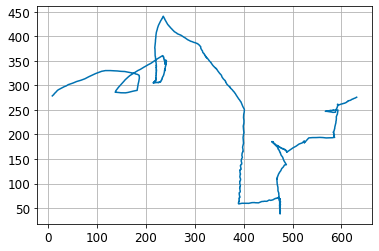

In [80]:
plt.plot(MLD.X/1e3, MLD.Y/1e3)
plt.grid()

In [81]:
# Estimate along track distance
dist = gt.utils.distance(MLD.longitude, MLD.latitude)

MLD['distance'] = xr.DataArray(np.cumsum(dist), 
                               dims= ['dives'])

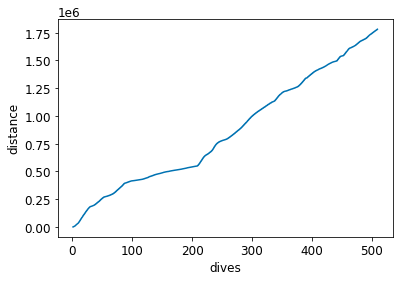

In [83]:
MLD['distance'].plot()

### Density Ratios and Turner Angles

Text(0, 0.5, 'CT')

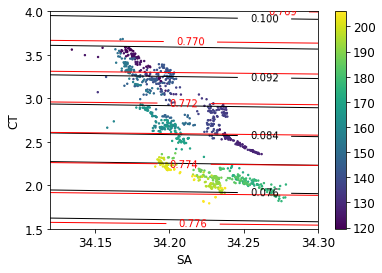

In [98]:

rho0=1000
alpha_grid = gsw.alpha(SA_grid, CT_grid,50)*rho0
beta_grid = gsw.beta(SA_grid, CT_grid,50)*rho0

CS = plt.contour(SA_lin, CT_lin, alpha_grid, linewidths=1, colors='k')
plt.clabel(CS, inline=1, fontsize=10)

CS = plt.contour(SA_lin, CT_lin, beta_grid, linewidths=1, colors='r')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(MLD.SA, 
            MLD.CT, 
            s=2.,
            c=MLD.days)
plt.colorbar()


plt.xlim([34.12, 34.3])
plt.xlabel('SA')
plt.ylabel('CT')

In [116]:
alphadT = alpha* MLD.CT.diff('dives') *rho0
betadS = beta* MLD.SA.diff('dives')*rho0
R = alphadT/betadS

In [127]:
Tu = np.arctan(R)

Text(0, 0.5, '$\\beta$ dS')

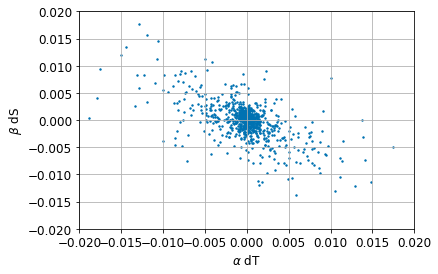

In [115]:
plt.scatter(alphadT, betadS, s=2.)
lims = [-0.02, 0.02]
plt.xlim(lims)
plt.ylim(lims)

plt.grid()

plt.xlabel(r'$\alpha$ dT')
plt.ylabel(r'$\beta$ dS')

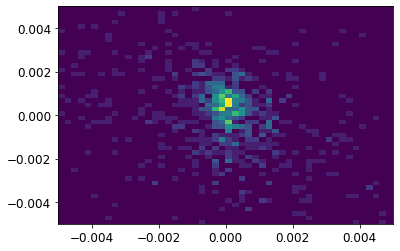

In [137]:
plt.hist2d(alphadT, betadS, bins=np.linspace(-0.005,0.005, 51));

Text(0.5, 0, 'R')

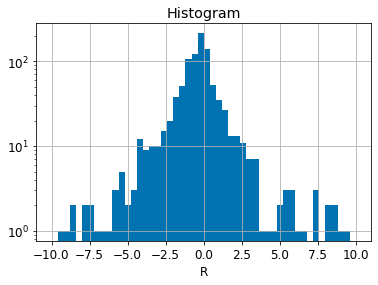

In [147]:
R.plot.hist(bins=np.linspace(-10,10,51));
plt.yscale('log')
plt.grid()
plt.xlabel('R')

Text(0.5, 0, 'Tu')

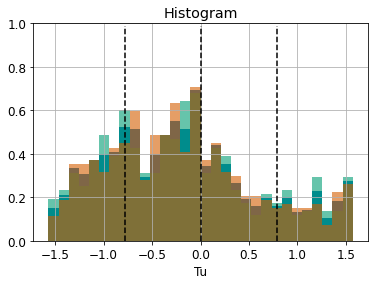

In [152]:
Tu.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,31), density=True);
Tu.sel(dives=slice(0,250)).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,31), density=True, alpha=0.6);
Tu.sel(dives=slice(250,600)).plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,31), density=True, alpha=0.6);
#plt.yscale('log')
plt.vlines([-np.pi/4 , 0 , np.pi/4], 0, 0.99, colors='k', linestyle='--')
plt.grid()
plt.ylim([0, 1])
plt.xlabel('Tu')

In [ ]:
Tu.plot.hist(bins=np.linspace(-np.pi/2,np.pi/2,31), density=True);
#plt.yscale('log')
plt.vlines([-np.pi/4 , 0 , np.pi/4], 0, 0.99, colors='k', linestyle='--')
plt.grid()
plt.ylim([0, 1])
plt.xlabel('Tu')

(array([314., 217.,  74.,  65.,  48.,  29.,  31.,  42.,  50.,  40.,  19.,
         21.,  14.,  16.,  12.,   7.,   1.,   0.,   1.,   1.]),
 array([3.04380089e+00, 4.76389663e+02, 9.49735526e+02, 1.42308139e+03,
        1.89642725e+03, 2.36977311e+03, 2.84311897e+03, 3.31646484e+03,
        3.78981070e+03, 4.26315656e+03, 4.73650242e+03, 5.20984829e+03,
        5.68319415e+03, 6.15654001e+03, 6.62988587e+03, 7.10323174e+03,
        7.57657760e+03, 8.04992346e+03, 8.52326932e+03, 8.99661518e+03,
        9.46996105e+03]),
 <BarContainer object of 20 artists>)

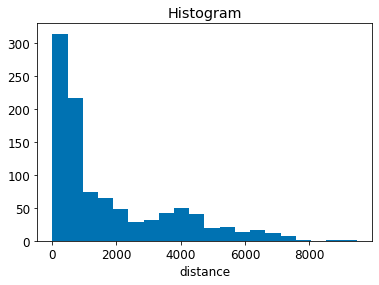

In [150]:
MLD.distance.diff('dives').plot.hist(bins=20)

The above analysis suggests that roughly in our domain the Tu has a peak at slightly less than 0, which would correspont to strong salinity fronts. There is a second peak that is present at -pi/4, which would correspond to aligned fronts where T and S gradients make a comparable impact on the gradients. 

This suggests that we might want to look at this in more detail. One thing to consider would be these structures at different scales. 